# Titanic

### Predict who would've survived the Titanic?



Understanding the data :

**Survival :** 0 = No, 1 = Yes

**Pclass :** A proxy for socio-economic status (SES) 1st = Upper 2nd = Middle 3rd = Lower

**sibsp :** The # of siblings / spouses aboard the Titanic Sibling = brother, sister, stepbrother, stepsister Spouse = husband, wife (mistresses and fiancés were ignored)

**parch :** The # of parents / children aboard the Titanic Parent = mother, father Child = daughter, son, stepdaughter, stepson Some children travelled only with a nanny, therefore parch=0 for them.

**Ticket :** Ticket number

**Fare :** Passenger fare

**Cabin :** Cabin number embarked

Port of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

Name, Sex , Age are self-explanatory

## Importing all necessary libraries

In [1]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

### Load the data

In [2]:
# Import train & test data 
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv')

## Understanding of the data

In [3]:
# View the training data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:ylabel='Frequency'>

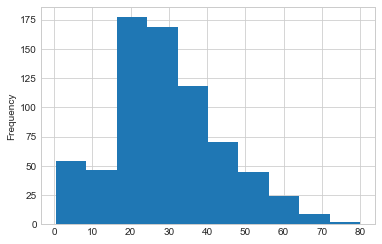

In [4]:
train.Age.plot.hist()

In [5]:
# View the test data
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
# View the example submisison dataframe
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### Data Descriptions

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Data Exploration

explore each of these features individually, go through each column iteratively and see which ones to use in our first models.

Some may need more preprocessing than others to get ready.

<AxesSubplot:>

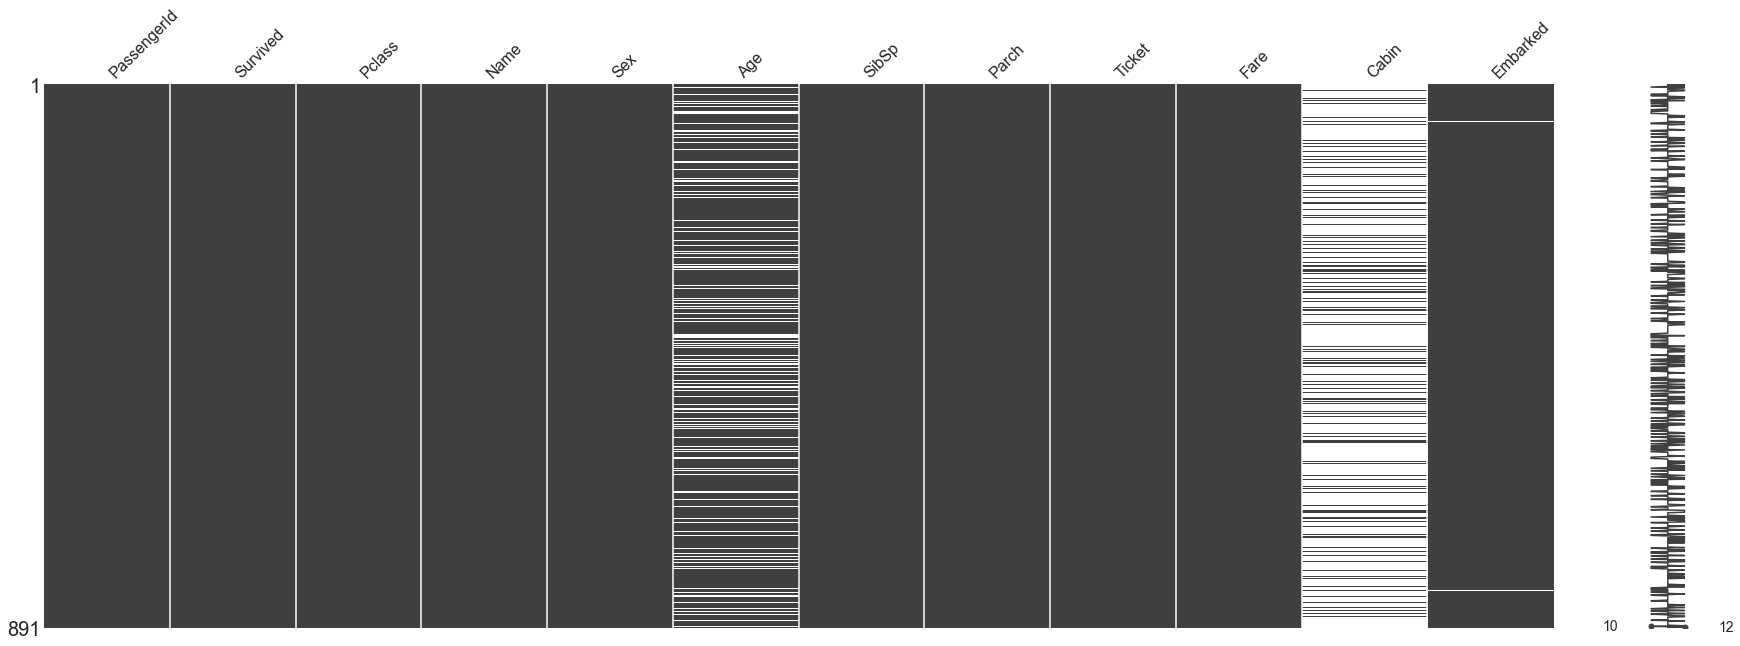

In [8]:
# Plot graphic of missing values
missingno.matrix(train, figsize = (30,10))

In [9]:
# Number of missing values
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables

In [11]:
# Different data types in the dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### 1. Target Feature: Survived

**Description:** Whether the passenger survived or not.
    
Key: 0 = did not survive, 1 = survived
    
This is the variable we want our machine learning model to predict based off all the others.

0    549
1    342
Name: Survived, dtype: int64


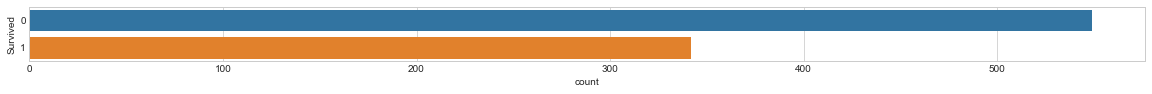

In [12]:
# How many people survived?
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train);
print(train.Survived.value_counts())

In [13]:
# Add this to subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [14]:
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [15]:
df_con.head()

,Survived
0,0
1,1
2,1
3,1
4,0


### 2. Feature: Pclass

**Description:** The ticket class of the passenger.
    
Key: 1 = 1st, 2 = 2nd, 3 = 3rd

<AxesSubplot:xlabel='Pclass', ylabel='Density'>

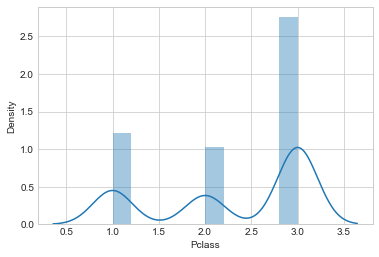

In [16]:
sns.distplot(train.Pclass)

In [17]:
# There are no missing values in Pclass, so let's add it to our sub dataframes.
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass'] 

### 3. Feature: Name
    
**Description:** The name of the passenger.

In [18]:
# How many different names are there?
train.Name.value_counts()

Quick, Miss. Phyllis May                                                              1
Elias, Mr. Tannous                                                                    1
Smiljanic, Mr. Mile                                                                   1
Culumovic, Mr. Jeso                                                                   1
Leonard, Mr. Lionel                                                                   1
                                                                                     ..
Hassab, Mr. Hammad                                                                    1
Silvey, Mrs. William Baird (Alice Munger)                                             1
Hart, Mr. Henry                                                                       1
Penasco y Castellana, Mrs. Victor de Satode (Maria Josefa Perez de Soto y Vallejo)    1
Gustafsson, Mr. Johan Birger                                                          1
Name: Name, Length: 891, dtype: 

Every row has a unique name. This is equivalent to the passenger ID. But name could be used differently.

**Note:** Because of so many different names and to keep this EDA fast, we won't move forward using the name variable.

### 4. Feature: Sex

**Description:** The sex of the passenger (male or female).

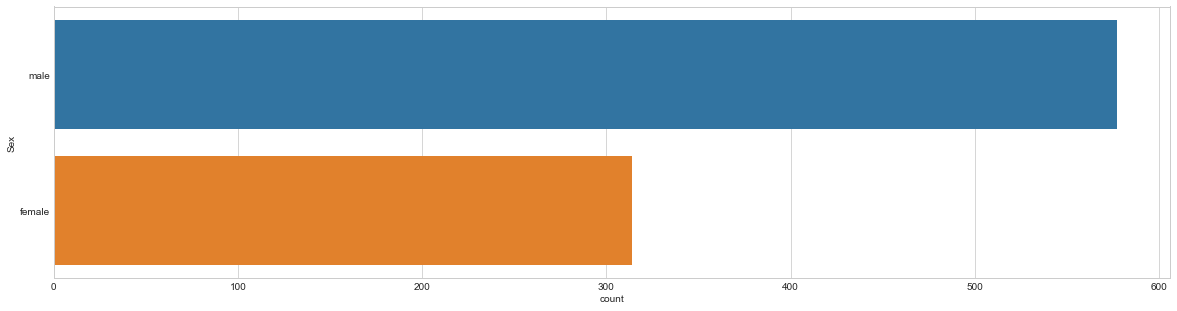

In [19]:
# view the distribution of Sex
plt.figure(figsize=(20, 5))
sns.countplot(y="Sex", data=train);

In [20]:
train.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [21]:
# add Sex to the subset dataframes
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

df_con['Sex'] = train['Sex']

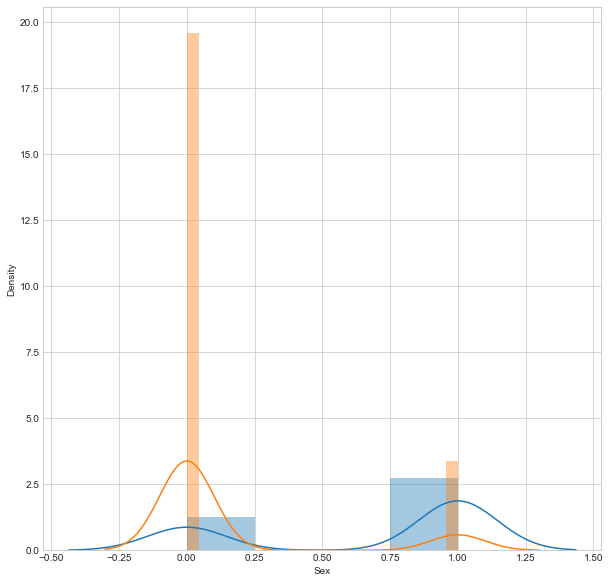

In [22]:
# How does the Sex variable look compared to Survival?
# We can see this because they're both binarys.
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

### 5. Feature: Age

**Description:** The age of the passenger.

In [23]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

### 6. Feature: SibSp

**Description:** The number of siblings/spouses the passenger has aboard the Titanic.

In [24]:
# What values are there?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [25]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

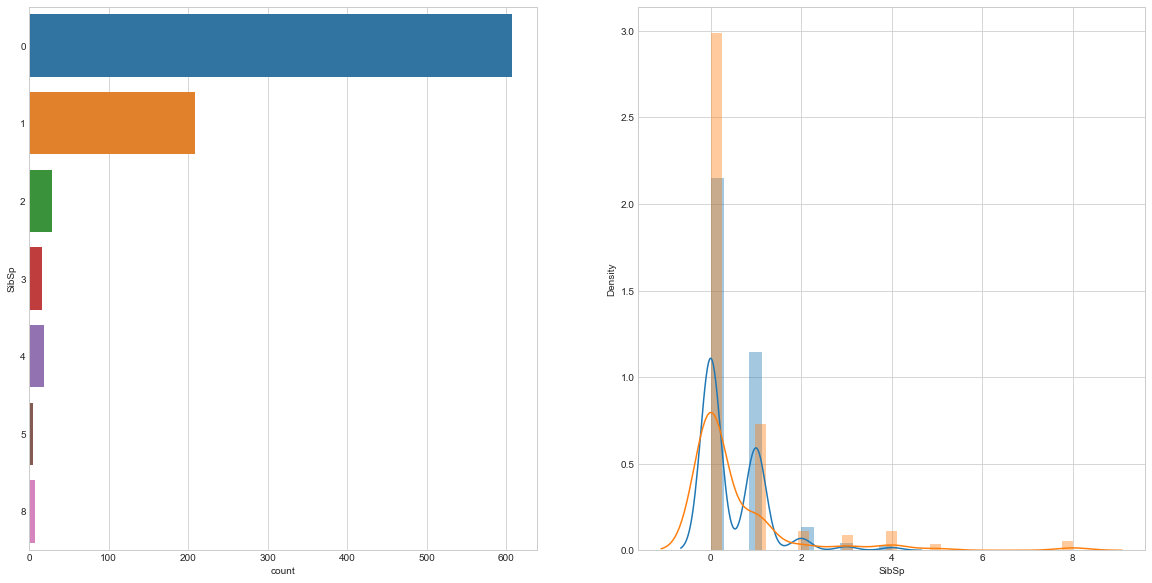

In [26]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

### 7. Feature: Parch

**Description:** The number of parents/children the passenger has aboard the Titanic.

In [27]:
# What values are there?
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [28]:
# Add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

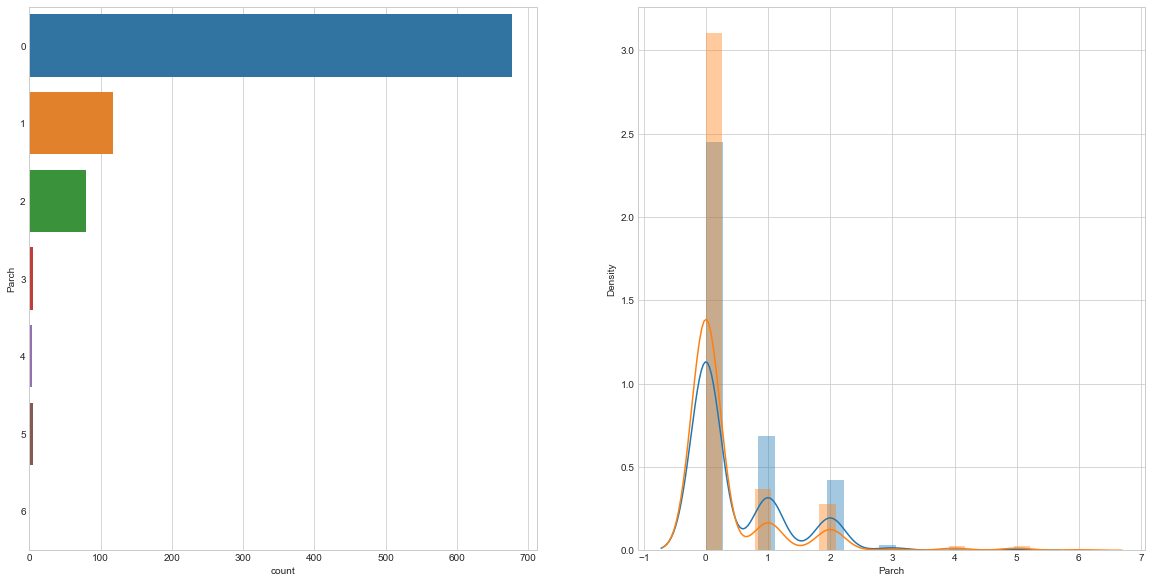

In [29]:
# Visualise the counts of Parch and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

### 8. Feature: Ticket

**Description:** The ticket number of the boarding passenger.

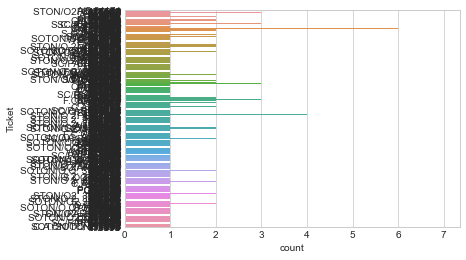

In [30]:
# How many kinds of ticket are there?
sns.countplot(y="Ticket", data=train);

In [31]:
# How many kinds of ticket are there?
train.Ticket.value_counts()

CA. 2343         7
347082           7
1601             7
CA 2144          6
3101295          6
                ..
SC/PARIS 2133    1
4579             1
113773           1
367232           1
248747           1
Name: Ticket, Length: 681, dtype: int64

In [32]:
# How many unique kinds of Ticket are there?
print(format(len(train.Ticket.unique())))

681


### 9. Feature: Fare

**Description:** How much the ticket cost.

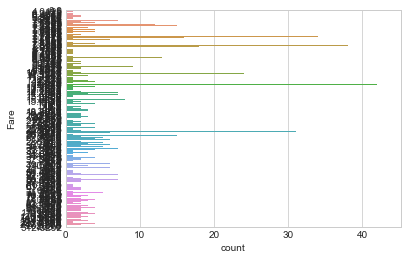

In [33]:
# How many different values of Fare are there?
sns.countplot(y="Fare", data=train);

In [34]:
# How many unique kinds of Fare are there?
print(format(len(train.Fare.unique())))

248


Because Fare is a float (number) let's add it as it is to our continuous sub dataframe but to add it to our categorical sub dataframe, we'll cut it into bins.

In [35]:
# Add Fare to sub dataframes
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised 

In [36]:
# What do our Fare bins look like?
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

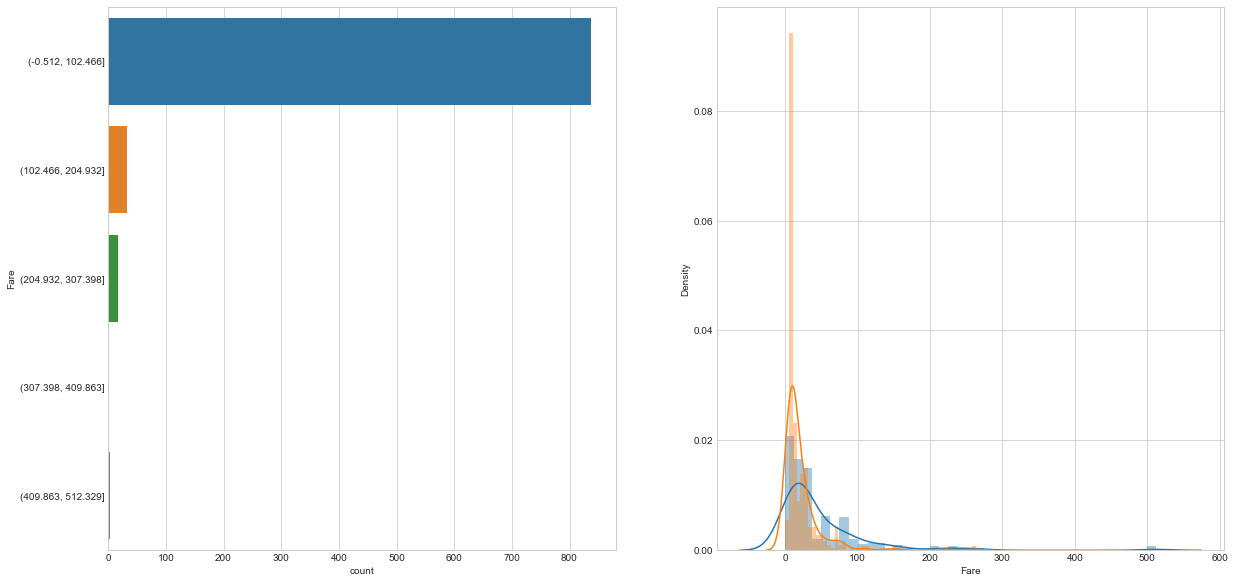

In [37]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

### 10. Feature: Cabin

**Description:** The cabin number where the passenger was staying.    

In [38]:
# What do the Cabin values look like?
train.Cabin.value_counts()

G6             4
C23 C25 C27    4
B96 B98        4
D              3
F33            3
              ..
A36            1
E46            1
A14            1
E40            1
D46            1
Name: Cabin, Length: 147, dtype: int64

Since there are too many missing values, we won't use Cabin for our initial models and won't add it to our sub dataframes.

### 11. Feature: Embarked

**Description:** The port where the passenger boarded the Titanic.
    
Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [39]:
# What kind of values are in Embarked?
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked is a categorical variable because there are 3 categories which a passenger could have boarded on.

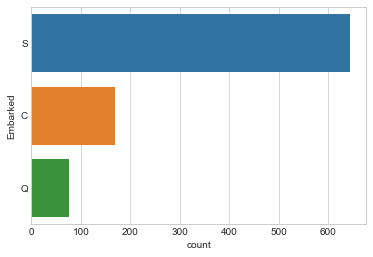

In [40]:
# What do the counts look like?
sns.countplot(y='Embarked', data=train);

In [41]:
# Add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [42]:
# Remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


We've removed the two rows with missing values for Embarked, now we can add Embarked to our sub dataframes.

## Feature Encoding
Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

We will encode our binned dataframe (`df_bin`) with one-hot encoding and our continuous dataframe (`df_con`) with the label encoding function from `sklearn`.

In [43]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S


In [44]:
# One-hot encode binned variables
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [45]:
df_con.head(10)

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S
5,0,3,male,0,0,8.4583,Q
6,0,1,male,0,0,51.8625,S
7,0,3,male,3,1,21.0750,S
8,1,3,female,0,2,11.1333,S
9,1,2,female,1,0,30.0708,C


In [46]:
# One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

In [47]:
# Combine the one hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [48]:
# Let's look at df_con_enc
df_con_enc.head(20)

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1
5,0,0,0,8.4583,0,1,0,0,1,0,0,1
6,0,0,0,51.8625,0,0,1,0,1,1,0,0
7,0,3,1,21.0750,0,0,1,0,1,0,0,1
8,1,0,2,11.1333,0,0,1,1,0,0,0,1
9,1,1,0,30.0708,1,0,0,1,0,0,1,0


## Start Building Machine Learning Models
Now our data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

In [49]:
# Seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [50]:
selected_df.head()

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1


In [51]:
# Split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [52]:
# Shape of the data (without labels)
X_train.shape

(889, 11)

In [53]:
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [54]:
# Shape of the labels
y_train.shape

(889,)

### Machine learning algorithms

In [55]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

### Logistic Regression

In [56]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.98
Accuracy CV 10-Fold: 79.42
Running Time: 0:00:04.823006


### K-Nearest Neighbours

In [57]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 83.46
Accuracy CV 10-Fold: 76.72
Running Time: 0:00:00.243846


### Gaussian Naive Bayes

In [58]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 78.52
Accuracy CV 10-Fold: 77.95
Running Time: 0:00:00.075950


### Linear Support Vector Machines (SVC)

In [59]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 78.07
Accuracy CV 10-Fold: 76.38
Running Time: 0:00:00.281826


### Decision Tree Classifier

In [60]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 80.2
Running Time: 0:00:00.105935


### CatBoost Algorithm
CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

For more on CatBoost and the methods it uses to deal with categorical variables, check out the [CatBoost docs](https://catboost.ai/).

In [74]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

This means Catboost has picked up that all variables except `Fare` can be treated as categorical.

In [75]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [76]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [77]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009797
0:	learn: 0.6862830	total: 187ms	remaining: 3m 6s
1:	learn: 0.6809444	total: 208ms	remaining: 1m 43s
2:	learn: 0.6751692	total: 239ms	remaining: 1m 19s
3:	learn: 0.6689060	total: 265ms	remaining: 1m 6s
4:	learn: 0.6632144	total: 294ms	remaining: 58.5s
5:	learn: 0.6576488	total: 314ms	remaining: 52.1s
6:	learn: 0.6544441	total: 325ms	remaining: 46s
7:	learn: 0.6490635	total: 352ms	remaining: 43.6s
8:	learn: 0.6443241	total: 379ms	remaining: 41.7s
9:	learn: 0.6395935	total: 409ms	remaining: 40.5s
10:	learn: 0.6345186	total: 429ms	remaining: 38.6s
11:	learn: 0.6305316	total: 451ms	remaining: 37.1s
12:	learn: 0.6275610	total: 464ms	remaining: 35.3s
13:	learn: 0.6225020	total: 487ms	remaining: 34.3s
14:	learn: 0.6179503	total: 513ms	remaining: 33.7s
15:	learn: 0.6140480	total: 524ms	remaining: 32.3s
16:	learn: 0.6100034	total: 542ms	remaining: 31.3s
17:	learn: 0.6049646	total: 567ms	remaining: 31s
18:	learn: 0.6025760	total: 577ms	remaining: 29.8s
19:	learn: 0.

166:	learn: 0.4226186	total: 4.08s	remaining: 20.4s
167:	learn: 0.4222141	total: 4.11s	remaining: 20.3s
168:	learn: 0.4219366	total: 4.13s	remaining: 20.3s
169:	learn: 0.4216245	total: 4.15s	remaining: 20.3s
170:	learn: 0.4213900	total: 4.18s	remaining: 20.2s
171:	learn: 0.4210836	total: 4.2s	remaining: 20.2s
172:	learn: 0.4208199	total: 4.22s	remaining: 20.2s
173:	learn: 0.4206421	total: 4.25s	remaining: 20.2s
174:	learn: 0.4201114	total: 4.27s	remaining: 20.1s
175:	learn: 0.4198212	total: 4.3s	remaining: 20.1s
176:	learn: 0.4195834	total: 4.33s	remaining: 20.1s
177:	learn: 0.4195685	total: 4.34s	remaining: 20s
178:	learn: 0.4194809	total: 4.36s	remaining: 20s
179:	learn: 0.4191368	total: 4.39s	remaining: 20s
180:	learn: 0.4185960	total: 4.42s	remaining: 20s
181:	learn: 0.4184559	total: 4.45s	remaining: 20s
182:	learn: 0.4180542	total: 4.49s	remaining: 20s
183:	learn: 0.4178579	total: 4.51s	remaining: 20s
184:	learn: 0.4175684	total: 4.54s	remaining: 20s
185:	learn: 0.4173356	total: 4

328:	learn: 0.3926321	total: 8s	remaining: 16.3s
329:	learn: 0.3926315	total: 8.01s	remaining: 16.3s
330:	learn: 0.3925085	total: 8.03s	remaining: 16.2s
331:	learn: 0.3921820	total: 8.05s	remaining: 16.2s
332:	learn: 0.3920570	total: 8.07s	remaining: 16.2s
333:	learn: 0.3918707	total: 8.1s	remaining: 16.2s
334:	learn: 0.3917635	total: 8.12s	remaining: 16.1s
335:	learn: 0.3916127	total: 8.14s	remaining: 16.1s
336:	learn: 0.3914735	total: 8.16s	remaining: 16.1s
337:	learn: 0.3914486	total: 8.2s	remaining: 16.1s
338:	learn: 0.3912764	total: 8.22s	remaining: 16s
339:	learn: 0.3911365	total: 8.24s	remaining: 16s
340:	learn: 0.3910828	total: 8.26s	remaining: 16s
341:	learn: 0.3910413	total: 8.28s	remaining: 15.9s
342:	learn: 0.3910351	total: 8.3s	remaining: 15.9s
343:	learn: 0.3908388	total: 8.32s	remaining: 15.9s
344:	learn: 0.3907468	total: 8.35s	remaining: 15.8s
345:	learn: 0.3905556	total: 8.37s	remaining: 15.8s
346:	learn: 0.3905329	total: 8.4s	remaining: 15.8s
347:	learn: 0.3904624	tot

495:	learn: 0.3770363	total: 11.7s	remaining: 11.9s
496:	learn: 0.3769634	total: 11.7s	remaining: 11.9s
497:	learn: 0.3769625	total: 11.7s	remaining: 11.8s
498:	learn: 0.3768613	total: 11.8s	remaining: 11.8s
499:	learn: 0.3768611	total: 11.8s	remaining: 11.8s
500:	learn: 0.3768153	total: 11.8s	remaining: 11.7s
501:	learn: 0.3767849	total: 11.8s	remaining: 11.7s
502:	learn: 0.3765500	total: 11.8s	remaining: 11.7s
503:	learn: 0.3763980	total: 11.9s	remaining: 11.7s
504:	learn: 0.3763692	total: 11.9s	remaining: 11.7s
505:	learn: 0.3763085	total: 11.9s	remaining: 11.6s
506:	learn: 0.3761631	total: 12s	remaining: 11.6s
507:	learn: 0.3760934	total: 12s	remaining: 11.6s
508:	learn: 0.3760498	total: 12s	remaining: 11.6s
509:	learn: 0.3760150	total: 12.1s	remaining: 11.6s
510:	learn: 0.3759970	total: 12.1s	remaining: 11.6s
511:	learn: 0.3759798	total: 12.2s	remaining: 11.6s
512:	learn: 0.3759568	total: 12.2s	remaining: 11.6s
513:	learn: 0.3758344	total: 12.2s	remaining: 11.6s
514:	learn: 0.3757

661:	learn: 0.3640790	total: 15.8s	remaining: 8.06s
662:	learn: 0.3640602	total: 15.8s	remaining: 8.03s
663:	learn: 0.3639463	total: 15.8s	remaining: 8.01s
664:	learn: 0.3639302	total: 15.9s	remaining: 7.99s
665:	learn: 0.3638903	total: 15.9s	remaining: 7.96s
666:	learn: 0.3637239	total: 15.9s	remaining: 7.93s
667:	learn: 0.3635881	total: 15.9s	remaining: 7.91s
668:	learn: 0.3634772	total: 15.9s	remaining: 7.89s
669:	learn: 0.3634068	total: 16s	remaining: 7.87s
670:	learn: 0.3633759	total: 16s	remaining: 7.84s
671:	learn: 0.3631802	total: 16s	remaining: 7.82s
672:	learn: 0.3631026	total: 16s	remaining: 7.79s
673:	learn: 0.3630056	total: 16.1s	remaining: 7.77s
674:	learn: 0.3628564	total: 16.1s	remaining: 7.74s
675:	learn: 0.3628277	total: 16.1s	remaining: 7.71s
676:	learn: 0.3628277	total: 16.1s	remaining: 7.68s
677:	learn: 0.3627016	total: 16.1s	remaining: 7.66s
678:	learn: 0.3626910	total: 16.1s	remaining: 7.63s
679:	learn: 0.3624607	total: 16.2s	remaining: 7.61s
680:	learn: 0.362390

823:	learn: 0.3530893	total: 19.4s	remaining: 4.15s
824:	learn: 0.3528000	total: 19.5s	remaining: 4.13s
825:	learn: 0.3527557	total: 19.5s	remaining: 4.11s
826:	learn: 0.3527494	total: 19.5s	remaining: 4.08s
827:	learn: 0.3527097	total: 19.5s	remaining: 4.06s
828:	learn: 0.3525818	total: 19.5s	remaining: 4.03s
829:	learn: 0.3525719	total: 19.6s	remaining: 4.01s
830:	learn: 0.3523327	total: 19.6s	remaining: 3.98s
831:	learn: 0.3523023	total: 19.6s	remaining: 3.96s
832:	learn: 0.3522949	total: 19.6s	remaining: 3.93s
833:	learn: 0.3521358	total: 19.7s	remaining: 3.91s
834:	learn: 0.3521053	total: 19.7s	remaining: 3.89s
835:	learn: 0.3520985	total: 19.7s	remaining: 3.86s
836:	learn: 0.3520746	total: 19.7s	remaining: 3.84s
837:	learn: 0.3519963	total: 19.7s	remaining: 3.82s
838:	learn: 0.3519587	total: 19.8s	remaining: 3.79s
839:	learn: 0.3518946	total: 19.8s	remaining: 3.77s
840:	learn: 0.3518871	total: 19.8s	remaining: 3.75s
841:	learn: 0.3518257	total: 19.8s	remaining: 3.72s
842:	learn: 

984:	learn: 0.3408345	total: 23.5s	remaining: 358ms
985:	learn: 0.3407755	total: 23.6s	remaining: 335ms
986:	learn: 0.3405983	total: 23.6s	remaining: 311ms
987:	learn: 0.3404887	total: 23.7s	remaining: 287ms
988:	learn: 0.3404766	total: 23.7s	remaining: 263ms
989:	learn: 0.3404401	total: 23.7s	remaining: 240ms
990:	learn: 0.3403797	total: 23.7s	remaining: 216ms
991:	learn: 0.3403515	total: 23.8s	remaining: 192ms
992:	learn: 0.3402624	total: 23.8s	remaining: 168ms
993:	learn: 0.3402175	total: 23.8s	remaining: 144ms
994:	learn: 0.3399939	total: 23.9s	remaining: 120ms
995:	learn: 0.3399342	total: 23.9s	remaining: 95.9ms
996:	learn: 0.3398669	total: 23.9s	remaining: 72ms
997:	learn: 0.3398219	total: 23.9s	remaining: 48ms
998:	learn: 0.3397748	total: 24s	remaining: 24ms
999:	learn: 0.3396214	total: 24s	remaining: 0us


### Perform CatBoost cross-validation

In [78]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6746718	test: 0.6751020	best: 0.6751020 (0)
1:	learn: 0.6573540	test: 0.6583602	best: 0.6583602 (1)
2:	learn: 0.6408329	test: 0.6429257	best: 0.6429257 (2)
3:	learn: 0.6253924	test: 0.6283059	best: 0.6283059 (3)
4:	learn: 0.6114190	test: 0.6150989	best: 0.6150989 (4)
5:	learn: 0.6004513	test: 0.6048524	best: 0.6048524 (5)
6:	learn: 0.5900482	test: 0.5949158	best: 0.5949158 (6)
7:	learn: 0.5800356	test: 0.5853301	best: 0.5853301 (7)
8:	learn: 0.5702086	test: 0.5757925	best: 0.5757925 (8)
9:	learn: 0.5612227	test: 0.5675857	best: 0.5675857 (9)
10:	learn: 0.5522686	test: 0.5589941	best: 0.5589941 (10)
11:	learn: 0.5447302	test: 0.5517930	best: 0.5517930 (11)
12:	learn: 0.5377424	test: 0.5449873	best: 0.5449873 (12)
13:	learn: 0.5305336	test: 0.5382423	best: 0.5382423 (13)
14:	learn: 0.5241296	test: 0.5323280	best: 0.5323280 (14)
15:	learn: 0.5171284	test: 0.5265741	best: 0.5265741 (15)
16:	learn: 0.5113308	test: 0.5214578	best: 0.5214578 (16)
17:	learn: 0.5063945	test: 0.51688

137:	learn: 0.3795847	test: 0.4378873	best: 0.4375885 (133)
138:	learn: 0.3792507	test: 0.4378715	best: 0.4375885 (133)
139:	learn: 0.3789390	test: 0.4378660	best: 0.4375885 (133)
140:	learn: 0.3786555	test: 0.4378720	best: 0.4375885 (133)
141:	learn: 0.3784076	test: 0.4378774	best: 0.4375885 (133)
142:	learn: 0.3780534	test: 0.4378525	best: 0.4375885 (133)
143:	learn: 0.3777646	test: 0.4376841	best: 0.4375885 (133)
144:	learn: 0.3775321	test: 0.4378089	best: 0.4375885 (133)
145:	learn: 0.3772125	test: 0.4377624	best: 0.4375885 (133)
146:	learn: 0.3769816	test: 0.4376400	best: 0.4375885 (133)
147:	learn: 0.3767073	test: 0.4376571	best: 0.4375885 (133)
148:	learn: 0.3765399	test: 0.4376666	best: 0.4375885 (133)
149:	learn: 0.3762756	test: 0.4376520	best: 0.4375885 (133)
150:	learn: 0.3761288	test: 0.4377161	best: 0.4375885 (133)
151:	learn: 0.3759425	test: 0.4377006	best: 0.4375885 (133)
152:	learn: 0.3756349	test: 0.4378041	best: 0.4375885 (133)
153:	learn: 0.3754100	test: 0.4378911	be

271:	learn: 0.3459472	test: 0.4385234	best: 0.4375885 (133)
272:	learn: 0.3457528	test: 0.4385551	best: 0.4375885 (133)
273:	learn: 0.3454603	test: 0.4387147	best: 0.4375885 (133)
274:	learn: 0.3452277	test: 0.4387076	best: 0.4375885 (133)
275:	learn: 0.3448932	test: 0.4385902	best: 0.4375885 (133)
276:	learn: 0.3446775	test: 0.4386431	best: 0.4375885 (133)
277:	learn: 0.3443555	test: 0.4387197	best: 0.4375885 (133)
278:	learn: 0.3440870	test: 0.4386088	best: 0.4375885 (133)
279:	learn: 0.3439100	test: 0.4386475	best: 0.4375885 (133)
280:	learn: 0.3436557	test: 0.4385537	best: 0.4375885 (133)
281:	learn: 0.3434167	test: 0.4384602	best: 0.4375885 (133)
282:	learn: 0.3432213	test: 0.4383785	best: 0.4375885 (133)
283:	learn: 0.3429632	test: 0.4383874	best: 0.4375885 (133)
284:	learn: 0.3427279	test: 0.4383233	best: 0.4375885 (133)
285:	learn: 0.3423478	test: 0.4382080	best: 0.4375885 (133)
286:	learn: 0.3421475	test: 0.4380605	best: 0.4375885 (133)
287:	learn: 0.3419452	test: 0.4379682	be

424:	learn: 0.3078761	test: 0.4334475	best: 0.4334475 (424)
425:	learn: 0.3076162	test: 0.4334846	best: 0.4334475 (424)
426:	learn: 0.3073411	test: 0.4334663	best: 0.4334475 (424)
427:	learn: 0.3071439	test: 0.4333976	best: 0.4333976 (427)
428:	learn: 0.3068126	test: 0.4334408	best: 0.4333976 (427)
429:	learn: 0.3065275	test: 0.4334660	best: 0.4333976 (427)
430:	learn: 0.3063892	test: 0.4334690	best: 0.4333976 (427)
431:	learn: 0.3062245	test: 0.4335169	best: 0.4333976 (427)
432:	learn: 0.3059580	test: 0.4333669	best: 0.4333669 (432)
433:	learn: 0.3056850	test: 0.4335092	best: 0.4333669 (432)
434:	learn: 0.3054192	test: 0.4335065	best: 0.4333669 (432)
435:	learn: 0.3052204	test: 0.4334206	best: 0.4333669 (432)
436:	learn: 0.3050698	test: 0.4335151	best: 0.4333669 (432)
437:	learn: 0.3047879	test: 0.4334492	best: 0.4333669 (432)
438:	learn: 0.3046007	test: 0.4333917	best: 0.4333669 (432)
439:	learn: 0.3044894	test: 0.4334150	best: 0.4333669 (432)
440:	learn: 0.3043265	test: 0.4335227	be

566:	learn: 0.2803450	test: 0.4326869	best: 0.4320750 (502)
567:	learn: 0.2802396	test: 0.4327315	best: 0.4320750 (502)
568:	learn: 0.2800372	test: 0.4327737	best: 0.4320750 (502)
569:	learn: 0.2798955	test: 0.4327171	best: 0.4320750 (502)
570:	learn: 0.2797142	test: 0.4327944	best: 0.4320750 (502)
571:	learn: 0.2795052	test: 0.4327580	best: 0.4320750 (502)
572:	learn: 0.2793476	test: 0.4327594	best: 0.4320750 (502)
573:	learn: 0.2792016	test: 0.4327965	best: 0.4320750 (502)
574:	learn: 0.2790102	test: 0.4328137	best: 0.4320750 (502)
575:	learn: 0.2788207	test: 0.4327985	best: 0.4320750 (502)
576:	learn: 0.2786421	test: 0.4327223	best: 0.4320750 (502)
577:	learn: 0.2784512	test: 0.4326129	best: 0.4320750 (502)
578:	learn: 0.2782333	test: 0.4326789	best: 0.4320750 (502)
579:	learn: 0.2781486	test: 0.4326991	best: 0.4320750 (502)
580:	learn: 0.2780042	test: 0.4327089	best: 0.4320750 (502)
581:	learn: 0.2778893	test: 0.4326415	best: 0.4320750 (502)
582:	learn: 0.2776271	test: 0.4327159	be

707:	learn: 0.2590055	test: 0.4334517	best: 0.4320750 (502)
708:	learn: 0.2588383	test: 0.4333775	best: 0.4320750 (502)
709:	learn: 0.2587308	test: 0.4333990	best: 0.4320750 (502)
710:	learn: 0.2585979	test: 0.4334153	best: 0.4320750 (502)
711:	learn: 0.2584578	test: 0.4335655	best: 0.4320750 (502)	total: 3m 11s	remaining: 1m 17s
712:	learn: 0.2583358	test: 0.4335702	best: 0.4320750 (502)
713:	learn: 0.2582532	test: 0.4335350	best: 0.4320750 (502)
714:	learn: 0.2580981	test: 0.4336040	best: 0.4320750 (502)
715:	learn: 0.2580075	test: 0.4335891	best: 0.4320750 (502)
716:	learn: 0.2578844	test: 0.4335876	best: 0.4320750 (502)
717:	learn: 0.2577474	test: 0.4336855	best: 0.4320750 (502)
718:	learn: 0.2576249	test: 0.4337135	best: 0.4320750 (502)
719:	learn: 0.2574537	test: 0.4336854	best: 0.4320750 (502)
720:	learn: 0.2573392	test: 0.4337262	best: 0.4320750 (502)
721:	learn: 0.2572447	test: 0.4338422	best: 0.4320750 (502)
722:	learn: 0.2570845	test: 0.4338724	best: 0.4320750 (502)
723:	lea

846:	learn: 0.2406116	test: 0.4356938	best: 0.4320750 (502)
847:	learn: 0.2404884	test: 0.4357277	best: 0.4320750 (502)
848:	learn: 0.2403918	test: 0.4357099	best: 0.4320750 (502)
849:	learn: 0.2402659	test: 0.4356297	best: 0.4320750 (502)
850:	learn: 0.2401384	test: 0.4355980	best: 0.4320750 (502)
851:	learn: 0.2400293	test: 0.4356133	best: 0.4320750 (502)
852:	learn: 0.2399076	test: 0.4355977	best: 0.4320750 (502)
853:	learn: 0.2398083	test: 0.4355943	best: 0.4320750 (502)
854:	learn: 0.2397026	test: 0.4355511	best: 0.4320750 (502)
855:	learn: 0.2395772	test: 0.4354684	best: 0.4320750 (502)
856:	learn: 0.2394223	test: 0.4354681	best: 0.4320750 (502)
857:	learn: 0.2393145	test: 0.4354890	best: 0.4320750 (502)
858:	learn: 0.2392194	test: 0.4354568	best: 0.4320750 (502)
859:	learn: 0.2391231	test: 0.4355438	best: 0.4320750 (502)
860:	learn: 0.2390509	test: 0.4355163	best: 0.4320750 (502)
861:	learn: 0.2389130	test: 0.4355907	best: 0.4320750 (502)
862:	learn: 0.2388195	test: 0.4356582	be

997:	learn: 0.2242730	test: 0.4376085	best: 0.4320750 (502)
998:	learn: 0.2241963	test: 0.4376383	best: 0.4320750 (502)
999:	learn: 0.2241275	test: 0.4377127	best: 0.4320750 (502)	total: 4m 49s	remaining: 0us


In [79]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 83.91
Accuracy cross-validation 10-Fold: 81.32
Running Time: 0:04:50.655944


## Model Results

Which model had the best cross-validation accuracy?


### Regular accuracy scores

In [80]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 'Linear SVC', 
              'Decision Tree', 'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian,  
        acc_linear_svc, 
        acc_dt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
4,Decision Tree,92.46
5,CatBoost,83.91
0,KNN,83.46
1,Logistic Regression,79.98
2,Naive Bayes,78.52
3,Linear SVC,78.07


In [82]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 'Linear SVC', 
              'Decision Tree', 'CatBoost'] ,
    'Score': [
         acc_cv_knn, 
        acc_cv_log,  
        acc_cv_gaussian,  
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
5,CatBoost,81.32
4,Decision Tree,80.20
1,Logistic Regression,79.42
2,Naive Bayes,77.95
0,KNN,76.72
3,Linear SVC,76.38


We can see from the tables, the CatBoost model had the best results. Getting just under 82% is pretty good considering guessing would result in about 50% accuracy (0 or 1).

We'll pay more attention to the cross-validation figure.

Cross-validation is more robust than just the `.fit()` models as it does multiple passes over the data instead of one.

Because the CatBoost model got the best results, we'll use it for the next steps.

**Challenge:** How could you improve the CatBoost model?

## Feature Importance
Which features of the best model were most important for making predictions?

In [83]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png') 

,imp,col
4,0.992061,embarked_Q
3,1.213711,embarked_C
5,1.677219,embarked_S
9,2.178083,pclass_2
8,3.243021,pclass_1
0,10.797435,SibSp
10,11.205450,pclass_3
1,13.988886,Parch
2,15.753218,Fare
6,17.695520,sex_female


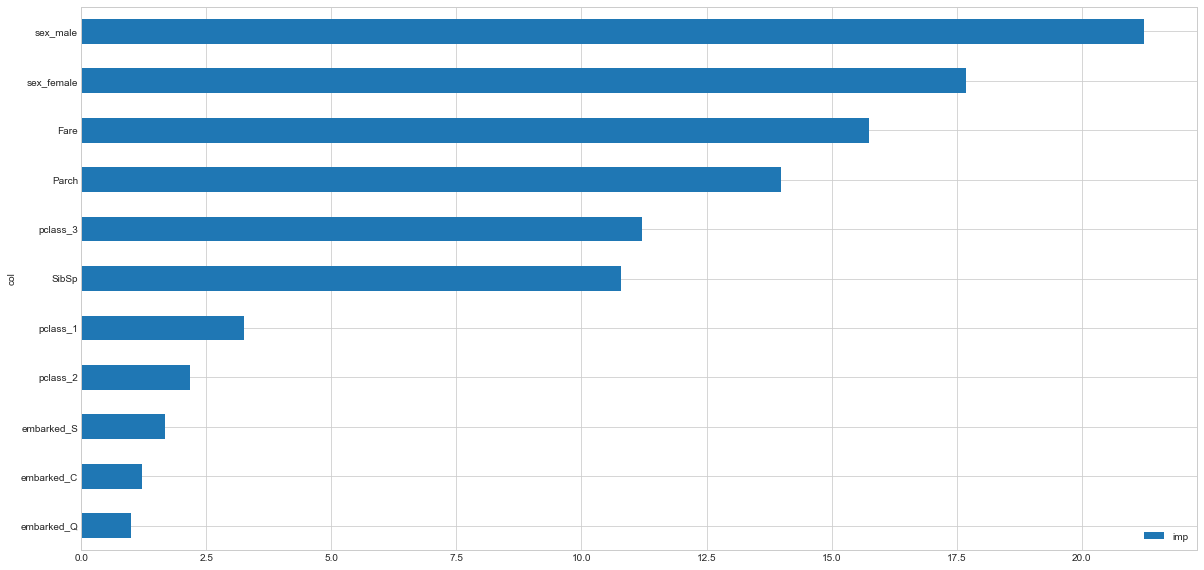

In [84]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)

#### Why would you want feature importance?

Featrue importance shows how much each feature contributed to the model.

You could take this information and remove features which don't contribute much to reduce dimenstionality (and save compute).

You could improve features which don't offer much to the overall model.

Or you could improve features which offer more to the model. In this case, there aren't many ways you could improve sex as it's already a binary.

Feature importance figures also show people who may not be familiar with the problem what features of their data are most important when it comes to making predictions with machine learning models.

## Precision and Recall

Precision and recall are two metrics which are used for cases where you have have an imbalanced classification problem.

For example, you may have 100,000 people and only 1 of them gets a certain disease. If your model predicts that all people don't have the disease, it only misses 1 in 100,000 so its accuracy is 99.999%. But this isn't really helpful.

This is where precision an recall come in.

**Recall** = a metric which measures a models ability to find all the relevant cases in a dataset.

Recall would be the models ability to find the 1 person in 100,000 who has the disease.

**Precision** = a metric which measures a models ability to correctly identify only relevant instances.

In our example, Precision would be if the model found the 1 person who had the disease, did they actually have the disease.

Combining the precision and recall, gives an **F1 score.**

These metrics will all fall between 0 and 1, with a higher value being better.

Although, they don't necessarily need to come into play for our Titantic problem, they're worth remembering for your future work.

In [85]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8286662683284687
Recall: 0.6833382352941176
F1: 0.7489789466084935
AUC: 0.8842839467480982


Recall is low, this means there's a higher amount of false negatives (predicting Did not survive when it was actually Survived).

Precision is higher therefore there's less false positives (predicting Survived, when it was actually Did not survive).

**Challenge:** What are some ways to visualise precision and recall?

## Submission
Let's use the model with the highest cross-validation accuracy score to make a prediction on the test dataset.

We want to make predictions on the same kind of columns our model is trained on.

So we have to select the subset of right columns of the `test` dateframe, encode them and make a prediction with our model.

In [66]:
# We need our test dataframe to look like this one
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [67]:
# Our test dataframe has some columns our model hasn't been trained on
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [68]:
# One hot encode the columns in the test data frame (like X_train)
test_embarked_one_hot = pd.get_dummies(test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [69]:
# Combine the test one hot encoded columns with test
test = pd.concat([test, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot], axis=1)

In [70]:
# Let's look at test, it should have one hot encoded columns now
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,0,0,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,1,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0,1,1,0,0,0,1


The columns in `test` have been converted to the same format at `df_con_enc`. Now we can make predictions on the `test` dataframe columns we built a model on.

We can find the columns we made predictions on with `X_train.columns`.

In [71]:
# Create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [86]:
# Make a prediction using the CatBoost model on the wanted columns
predictions = catboost_model.predict(test[wanted_test_columns])

In [87]:
# Our predictions array is comprised of 0's and 1's (Survived or Did Not Survive)
predictions[:20]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1],
      dtype=int64)

In [88]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [89]:
# What does our submission have to look like?
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [90]:
# Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [91]:
# How does our submission dataframe look?
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [92]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [93]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('../catboost_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [94]:
submissions_check = pd.read_csv("../catboost_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
